In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [2]:
import pandas as pd
file_path = '/home/abrar/Desktop/Code/Temporal HPC/normalized_data.csv'

# Read CSV and ensure datetime columns are parsed correctly
time_columns = ['submit_time', 'eligible_time', 'start_time', 'end_time', 'wait_time']
df = pd.read_csv(file_path, parse_dates=time_columns)
# Now 'df' contains the data from the second sheet

/tmp/ipykernel_5108/84532322.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_path, parse_dates=time_columns)


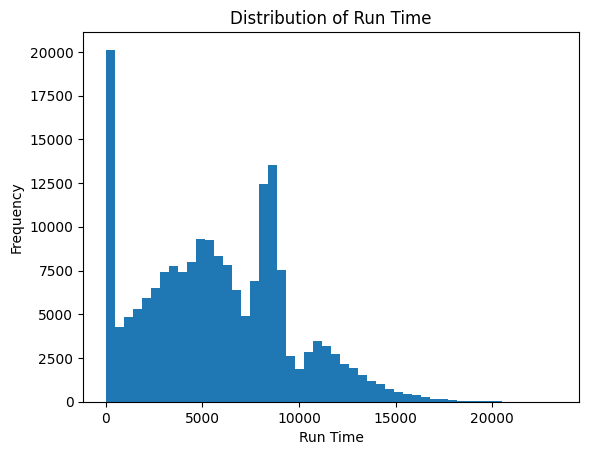

In [13]:
import matplotlib.pyplot as plt

df['run_time'].plot.hist(bins=50)
plt.title('Distribution of Run Time')
plt.xlabel('Run Time')
plt.ylabel('Frequency')
plt.show()

Temporal distribution analysis

In [3]:
# Temporal distribution analysis
# Convert submit_time to hour of day and day of week
df['hour_of_day'] = df['submit_time'].dt.hour
df['day_of_week'] = df['submit_time'].dt.day_name()
df['month'] = df['submit_time'].dt.month

# Get distributions
print("Hour of day distribution:")
print(df['hour_of_day'].value_counts().sort_index())
print("\nDay of week distribution:")
print(df['day_of_week'].value_counts())
print("\nMonthly distribution:")
print(df['month'].value_counts().sort_index())

Hour of day distribution:
hour_of_day
0      4680
1      3880
2      3645
3      3653
4      3834
5      4312
6      6420
7     11364
8     12706
9     11611
10    10179
11    11690
12     8799
13    13013
14    14091
15     9886
16     8403
17     8840
18     4967
19     7375
20     6316
21     6719
22     7563
23     7369
Name: count, dtype: int64

Day of week distribution:
day_of_week
Tuesday      34127
Wednesday    33466
Friday       32642
Thursday     31801
Monday       24452
Saturday     21010
Sunday       13817
Name: count, dtype: int64

Monthly distribution:
month
5     19376
6     33923
7     33178
8     29692
9     33887
10    41259
Name: count, dtype: int64


Job size and duration statistics

In [4]:
# Job size and duration statistics
print("\nJob size statistics:")
print(df[['num_cores_alloc', 'num_nodes_alloc', 'num_gpus_alloc', 'mem_alloc', 'run_time']].describe())

# Power usage statistics
print("\nPower usage statistics:")
print(df[['mean_cpu_power', 'mean_mem_power', 'mean_node_power']].describe())


Job size statistics:
       num_cores_alloc  num_nodes_alloc  num_gpus_alloc      mem_alloc  \
count    191315.000000    191315.000000   191315.000000  191315.000000   
mean        107.315872         1.173761        4.127314     213.540993   
std         106.953631         0.732607        3.212431     190.284860   
min           4.000000         1.000000        0.000000       0.000000   
25%          32.000000         1.000000        4.000000     118.000000   
50%         128.000000         1.000000        4.000000     237.000000   
75%         128.000000         1.000000        4.000000     237.000000   
max       20736.000000       162.000000      648.000000   38475.000000   

            run_time  
count  191315.000000  
mean     5767.922732  
std      3778.020112  
min         1.000000  
25%      2858.890321  
50%      5581.545522  
75%      8422.589206  
max     23330.168557  

Power usage statistics:
       mean_cpu_power  mean_mem_power  mean_node_power
count   191315.000000   

Calculate correlations between numerical columns

In [5]:
# Calculate correlations between numerical columns
corr_cols = ['cores_per_task', 'num_tasks', 'num_cores_alloc', 'num_nodes_alloc', 
             'num_gpus_alloc', 'mem_alloc', 'mean_cpu_power', 'mean_mem_power', 
             'mean_node_power', 'run_time']
correlation_matrix = df[corr_cols].corr()
print("\nCorrelation matrix:")
print(correlation_matrix)


Correlation matrix:
                 cores_per_task  num_tasks  num_cores_alloc  num_nodes_alloc  \
cores_per_task         1.000000  -0.259773         0.268369         0.048834   
num_tasks             -0.259773   1.000000         0.147112         0.238280   
num_cores_alloc        0.268369   0.147112         1.000000         0.838456   
num_nodes_alloc        0.048834   0.238280         0.838456         1.000000   
num_gpus_alloc         0.072371   0.128644         0.818108         0.883935   
mem_alloc              0.189469   0.145238         0.903711         0.862834   
mean_cpu_power         0.055080   0.346748         0.639818         0.672793   
mean_mem_power         0.049872   0.281220         0.781548         0.923168   
mean_node_power        0.657201   0.011314         0.669077         0.402031   
run_time               0.610215   0.028178         0.670590         0.436848   

                 num_gpus_alloc  mem_alloc  mean_cpu_power  mean_mem_power  \
cores_per_task      

appropriate groups based on the actual distribution

In [7]:

# For hour groups
df['hour_group'] = pd.cut(df['hour_of_day'], 
                         bins=[0, 6, 12, 18, 24], 
                         labels=['night', 'morning', 'afternoon', 'evening'])

# For core allocation, use custom bins based on the distribution we saw
df['size_group'] = pd.cut(df['num_cores_alloc'], 
                         bins=[0, 32, 64, 128, 256, float('inf')],
                         labels=['very_small', 'small', 'medium', 'large', 'very_large'])

# For runtime, use custom bins based on the distribution
df['runtime_group'] = pd.cut(df['run_time'],
                            bins=[0, 2000, 4000, 6000, 8000, float('inf')],
                            labels=['very_short', 'short', 'medium', 'long', 'very_long'])

# Create combined stratification feature
df['strata'] = df['hour_group'].astype(str) + '_' + \
               df['size_group'].astype(str) + '_' + \
               df['runtime_group'].astype(str)

# Check strata distribution
strata_counts = df['strata'].value_counts()
print("Number of strata:", len(strata_counts))
print("\nSample sizes per stratum:")
print("Min:", strata_counts.min())
print("Max:", strata_counts.max())
print("Mean:", strata_counts.mean())
print("Median:", strata_counts.median())

Number of strata: 90

Sample sizes per stratum:
Min: 1
Max: 14242
Mean: 2125.722222222222
Median: 325.0


Processing

In [8]:
# First, let's remove tiny strata that could cause issues
# Keep only strata with at least 20 samples to ensure meaningful splits
valid_strata = strata_counts[strata_counts >= 20].index
df_filtered = df[df['strata'].isin(valid_strata)].copy()

# Check how many samples we retained
print("Original samples:", len(df))
print("Filtered samples:", len(df_filtered))
print("Percentage retained:", (len(df_filtered)/len(df))*100, "%")

# Check new strata distribution
new_strata_counts = df_filtered['strata'].value_counts()
print("\nNew strata statistics:")
print("Number of strata:", len(new_strata_counts))
print("Min samples per stratum:", new_strata_counts.min())
print("Max samples per stratum:", new_strata_counts.max())

Original samples: 191315
Filtered samples: 191207
Percentage retained: 99.94354859786216 %

New strata statistics:
Number of strata: 78
Min samples per stratum: 20
Max samples per stratum: 14242


First Split for GNN Training (Power Prediction)

In [9]:
from sklearn.model_selection import train_test_split

# First split: separate out the final test set (10%)
train_val_idx, test_idx = train_test_split(
    df_filtered.index,
    test_size=0.1,
    stratify=df_filtered['strata'],
    random_state=42
)

# Then split remaining data into train (80% of total) and validation (10% of total)
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.111,  # 0.111 of 90% is 10% of total
    stratify=df_filtered.loc[train_val_idx, 'strata'],
    random_state=42
)

# Create the datasets
gnn_train_data = df_filtered.loc[train_idx]
gnn_val_data = df_filtered.loc[val_idx]
gnn_test_data = df_filtered.loc[test_idx]

# Print split sizes
print("GNN Training set size:", len(gnn_train_data))
print("GNN Validation set size:", len(gnn_val_data))
print("GNN Test set size:", len(gnn_test_data))

# Verify distribution preservation
for split_name, split_data in [("Train", gnn_train_data), 
                              ("Val", gnn_val_data), 
                              ("Test", gnn_test_data)]:
    print(f"\n{split_name} set statistics:")
    print(f"Mean CPU power: {split_data['mean_cpu_power'].mean():.2f}")
    print(f"Mean node power: {split_data['mean_node_power'].mean():.2f}")
    print(f"Average cores: {split_data['num_cores_alloc'].mean():.2f}")

GNN Training set size: 152984
GNN Validation set size: 19102
GNN Test set size: 19121

Train set statistics:
Mean CPU power: 142.37
Mean node power: 840.20
Average cores: 107.41

Val set statistics:
Mean CPU power: 141.78
Mean node power: 840.45
Average cores: 107.05

Test set statistics:
Mean CPU power: 142.78
Mean node power: 839.84
Average cores: 106.99


RL training sequences. For RL, we need to maintain temporal ordering while ensuring we have enough episodes for training. 

In [10]:
# Sort data by submit_time within each split
gnn_train_data = gnn_train_data.sort_values('submit_time')
gnn_val_data = gnn_val_data.sort_values('submit_time')
gnn_test_data = gnn_test_data.sort_values('submit_time')

# Create temporal sequences for RL
# Let's first analyze the time spans
for split_name, split_data in [("Train", gnn_train_data), 
                              ("Val", gnn_val_data), 
                              ("Test", gnn_test_data)]:
    time_span = split_data['submit_time'].max() - split_data['submit_time'].min()
    jobs_per_day = len(split_data) / (time_span.total_seconds() / (24*3600))
    print(f"\n{split_name} set:")
    print(f"Time span: {time_span.days} days")
    print(f"Average jobs per day: {jobs_per_day:.2f}")


Train set:
Time span: 160 days
Average jobs per day: 954.19

Val set:
Time span: 159 days
Average jobs per day: 119.65

Test set:
Time span: 159 days
Average jobs per day: 119.78


create the RL episodes. For HPC scheduling, we want episodes that:

- Are long enough to capture meaningful scheduling decisions
- Short enough to provide many training episodes
- Account for daily power price variations

In [12]:
import numpy as np
# Create episodes of 24 hours each (to capture full day cycles)
def create_episodes(df, episode_duration_hours=24):
    start_time = df['submit_time'].min()
    end_time = df['submit_time'].max()
    
    episodes = []
    current_time = start_time
    
    while current_time < end_time:
        episode_end = current_time + pd.Timedelta(hours=episode_duration_hours)
        
        # Get jobs submitted during this episode
        episode_jobs = df[
            (df['submit_time'] >= current_time) & 
            (df['submit_time'] < episode_end)
        ].copy()
        
        if len(episode_jobs) > 0:
            episodes.append(episode_jobs)
            
        current_time = episode_end
    
    return episodes

# Create episodes for each split
train_episodes = create_episodes(gnn_train_data)
val_episodes = create_episodes(gnn_val_data)
test_episodes = create_episodes(gnn_test_data)

# Print episode statistics
for split_name, split_episodes in [("Train", train_episodes), 
                                 ("Val", val_episodes), 
                                 ("Test", test_episodes)]:
    num_episodes = len(split_episodes)
    avg_jobs = np.mean([len(ep) for ep in split_episodes])
    min_jobs = np.min([len(ep) for ep in split_episodes])
    max_jobs = np.max([len(ep) for ep in split_episodes])
    
    print(f"\n{split_name} episodes:")
    print(f"Number of episodes: {num_episodes}")
    print(f"Average jobs per episode: {avg_jobs:.2f}")
    print(f"Min jobs per episode: {min_jobs}")
    print(f"Max jobs per episode: {max_jobs}")


Train episodes:
Number of episodes: 155
Average jobs per episode: 986.99
Min jobs per episode: 9
Max jobs per episode: 7888

Val episodes:
Number of episodes: 154
Average jobs per episode: 124.04
Min jobs per episode: 1
Max jobs per episode: 1119

Test episodes:
Number of episodes: 154
Average jobs per episode: 124.16
Min jobs per episode: 1
Max jobs per episode: 1115


GNN training structure

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

In [18]:
# Features for GNN (selected based on correlations with mean_node_power)
gnn_features = [
    'cores_per_task',     # Strong correlation (0.657)
    'num_cores_alloc',    # Strong correlation (0.669)
    'num_nodes_alloc',    # Important for node-level prediction
    'num_gpus_alloc',     # Relevant for power consumption
    'mem_alloc',          # Moderate correlation (0.580)
    'run_time'           # Strongest correlation (0.962)
]

# Single target variable
power_target = ['mean_node_power']

# Prepare the data structure for GNN
def prepare_gnn_data(df, features=gnn_features, target=power_target):
    """
    Prepare data for GNN training with KNN structure
    """
    # Normalize features (important for KNN)
    scaler = StandardScaler()
    X = scaler.fit_transform(df[features])
    y = df[target].values
    
    # For each job, we'll find k similar jobs
    k = 5  # Can be tuned
    knn = NearestNeighbors(n_neighbors=k+1)  # +1 because it includes the point itself
    knn.fit(X)
    
    # Get indices of k nearest neighbors for each job
    distances, indices = knn.kneighbors(X)
    
    return X, y, indices[:, 1:], scaler  # Exclude self from neighbors

print("Preparing GNN data splits:")
for split_name, split_data in [("Train", gnn_train_data), 
                              ("Val", gnn_val_data), 
                              ("Test", gnn_test_data)]:
    print(f"\n{split_name} set:")
    print(f"Number of jobs: {len(split_data)}")
    print(f"Mean node power: {split_data['mean_node_power'].mean():.2f}")
    print(f"Std node power: {split_data['mean_node_power'].std():.2f}")

Preparing GNN data splits:

Train set:
Number of jobs: 152984
Mean node power: 840.20
Std node power: 182.99

Val set:
Number of jobs: 19102
Mean node power: 840.45
Std node power: 183.30

Test set:
Number of jobs: 19121
Mean node power: 839.84
Std node power: 184.18


In [33]:
class PowerPredictionGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(PowerPredictionGNN, self).__init__()
        
        # Wider network
        self.node_embed = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        
        # Deeper graph convolutions
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        
        # More robust prediction head
        self.power_pred = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)
        )
        
    def forward(self, x, edge_index):
        # Initial embeddings
        x = self.node_embed(x)
        
        # Graph convolutions with residual connections
        x1 = F.relu(self.bn1(self.conv1(x, edge_index)))
        x2 = F.relu(self.bn2(self.conv2(x1, edge_index))) + x1
        x3 = F.relu(self.bn3(self.conv3(x2, edge_index))) + x2
        
        # Power prediction
        return self.power_pred(x3)
    
    
def create_graph_batch(features, neighbor_indices, targets, batch_size=1024):
    """
    Create graph batches ensuring consistent shapes between features and targets
    """
    graphs = []
    num_samples = len(features)
    
    for i in range(0, num_samples, batch_size):
        batch_end = min(i + batch_size, num_samples)
        batch_features = features[i:batch_end]
        batch_neighbors = neighbor_indices[i:batch_end]
        batch_targets = targets[i:batch_end]
        
        # Create edges based on KNN within this batch
        edge_index = []
        for job_idx, neighbors in enumerate(batch_neighbors):
            # Only add edges for neighbors that are within this batch
            valid_neighbors = [n - i for n in neighbors if i <= n < batch_end]
            for neighbor in valid_neighbors:
                edge_index.append([job_idx, neighbor])
                edge_index.append([neighbor, job_idx])
        
        if not edge_index:  # If no valid edges in this batch
            continue
            
        edge_index = torch.tensor(edge_index).t().contiguous()
        
        # Create graph with matching features and targets
        graph = Data(
            x=torch.FloatTensor(batch_features),
            edge_index=edge_index,
            y=torch.FloatTensor(batch_targets).unsqueeze(-1)  # Add dimension for consistency
        )
        graphs.append(graph)
    
    return graphs

# Modified training configuration
config = {
    'hidden_dim': 128,
    'learning_rate': 0.001,
    'batch_size': 1024,
    'epochs': 100,
    'early_stopping_patience': 15
}

# Print some statistics about the data
print(f"Total number of jobs in training: {len(gnn_train_data)}")
print(f"Total number of jobs in validation: {len(gnn_val_data)}")
print(f"Total number of jobs in test: {len(gnn_test_data)}")

# Initialize model and start training
input_dim = len(gnn_features)
model = PowerPredictionGNN(input_dim=input_dim)


print("\nPreparing data...")
train_graphs, val_graphs, test_graphs, scaler = prepare_training_data()

# Print graph statistics
print("\nGraph statistics:")
print(f"Number of training graphs: {len(train_graphs)}")
print(f"Number of validation graphs: {len(val_graphs)}")
print(f"Number of test graphs: {len(test_graphs)}")

print("\nSample graph details:")
if train_graphs:
    g = train_graphs[0]
    print(f"First training graph - Nodes: {g.x.size(0)}, Edges: {g.edge_index.size(1)//2}")

print("\nStarting training...")
train_losses, val_losses = train_gnn(model, train_graphs, val_graphs, config)

Total number of jobs in training: 152984
Total number of jobs in validation: 19102
Total number of jobs in test: 19121

Preparing data...
Calculating neighbors for training set...
Calculating neighbors for validation set...
Calculating neighbors for test set...


TypeError: create_graph_batch() missing 1 required positional argument: 'targets'

In [35]:
def power_prediction_loss(pred_power, true_power):
    """
    Custom loss function ensuring shape consistency
    """
    # Ensure shapes match
    pred_power = pred_power.squeeze()
    true_power = true_power.squeeze()
    
    # Check shapes are identical
    assert pred_power.shape == true_power.shape, f"Shape mismatch: pred={pred_power.shape}, true={true_power.shape}"
    
    # Compute normalized MSE
    pred_norm = (pred_power - pred_power.mean()) / (pred_power.std() + 1e-8)
    true_norm = (true_power - true_power.mean()) / (true_power.std() + 1e-8)
    
    mse_loss = F.mse_loss(pred_norm, true_norm)
    
    # Compute relative error
    relative_error = torch.abs(pred_power - true_power) / (torch.abs(true_power) + 1e-8)
    relative_loss = torch.mean(relative_error)
    
    return mse_loss + 0.1 * relative_loss

In [36]:
def prepare_rl_state(episode_df, gnn_model, scaler):
    """
    Prepare RL state with GNN power predictions
    """
    # Normalize features
    features_normalized = scaler.transform(episode_df[gnn_features])
    
    # Get power predictions from GNN
    with torch.no_grad():
        power_pred = gnn_model(features_normalized)
    
    # Create state dictionary
    state = {
        'job_features': episode_df[gnn_features].values,
        'predicted_power': power_pred.numpy(),
        'submit_time': episode_df['submit_time'].values,
        'time_of_day': episode_df['submit_time'].dt.hour.values
    }
    
    return state

In [46]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_gnn(model, train_graphs, val_graphs, config):
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    early_stopping = EarlyStopping(patience=config['early_stopping_patience'])
    
    train_losses = []
    val_losses = []
    
    for epoch in range(config['epochs']):
        # Training
        model.train()
        train_loss = 0
        for graph in train_graphs:
            optimizer.zero_grad()
            out = model(graph.x, graph.edge_index)
            loss = power_prediction_loss(out, graph.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for graph in val_graphs:
                out = model(graph.x, graph.edge_index)
                val_loss += power_prediction_loss(out, graph.y).item()
        
        train_loss /= len(train_graphs)
        val_loss /= len(val_graphs)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
            
    return train_losses, val_losses

# Evaluation metrics
def evaluate_predictions(model, test_graphs, power_scaler):
    model.eval()
    predictions = []
    true_values = []
    
    with torch.no_grad():
        for graph in test_graphs:
            pred = model(graph.x, graph.edge_index)
            # Ensure 2D shape before inverse transform
            pred = pred.squeeze().numpy().reshape(-1, 1)
            true = graph.y.squeeze().numpy().reshape(-1, 1)
            
            # Inverse transform
            pred = power_scaler.inverse_transform(pred)
            true = power_scaler.inverse_transform(true)
            
            predictions.extend(pred.flatten())
            true_values.extend(true.flatten())
    
    predictions = np.array(predictions)
    true_values = np.array(true_values)
    
    # Calculate metrics
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    
    results = {
        'mse': mse,
        'rmse': np.sqrt(mse),
        'mae': mae,
        'r2': r2,
        'mean_relative_error': np.mean(np.abs(predictions - true_values) / (true_values + 1e-8)),
        'mean_pred': np.mean(predictions),
        'mean_true': np.mean(true_values),
        'std_pred': np.std(predictions),
        'std_true': np.std(true_values)
    }
    
    # Add some percentile errors
    for p in [25, 50, 75, 90]:
        error_percentile = np.percentile(np.abs(predictions - true_values), p)
        results[f'error_p{p}'] = error_percentile
    
    return results

In [66]:


def calculate_neighbors(features, k=5):
    """Calculate k-nearest neighbors for each job"""
    knn = NearestNeighbors(n_neighbors=k+1)  # +1 because it includes the point itself
    knn.fit(features)
    distances, indices = knn.kneighbors(features)
    return indices[:, 1:]  # Exclude self from neighbors

def prepare_training_data():
    """
    Prepare training data with proper scaling
    """
    # Normalize features
    feature_scaler = StandardScaler()
    train_features = feature_scaler.fit_transform(gnn_train_data[gnn_features])
    val_features = feature_scaler.transform(gnn_val_data[gnn_features])
    test_features = feature_scaler.transform(gnn_test_data[gnn_features])
    
    # Scale power values
    power_scaler = StandardScaler()
    train_target = power_scaler.fit_transform(gnn_train_data[['mean_node_power']])
    val_target = power_scaler.transform(gnn_val_data[['mean_node_power']])
    test_target = power_scaler.transform(gnn_test_data[['mean_node_power']])
    
    # Calculate neighbor indices
    print("Calculating neighbors for training set...")
    train_neighbors = calculate_neighbors(train_features)
    print("Calculating neighbors for validation set...")
    val_neighbors = calculate_neighbors(val_features)
    print("Calculating neighbors for test set...")
    test_neighbors = calculate_neighbors(test_features)
    
    # Create graph batches
    train_graphs = create_graph_batch(train_features, train_neighbors, train_target)
    val_graphs = create_graph_batch(val_features, val_neighbors, val_target)
    test_graphs = create_graph_batch(test_features, test_neighbors, test_target)
    
    return train_graphs, val_graphs, test_graphs, feature_scaler, power_scaler


# Initialize model
input_dim = len(gnn_features)  # Number of features
model = PowerPredictionGNN(input_dim=input_dim)

# Print model architecture
print("Model architecture:")
print(model)

# Initialize and train
print("\nPreparing data...")
# Fix the unpacking to match the 5 return values
train_graphs, val_graphs, test_graphs, feature_scaler, power_scaler = prepare_training_data()

print("\nModel architecture:")
# Initialize model with the new architecture
model = PowerPredictionGNN(input_dim=len(gnn_features), hidden_dim=config['hidden_dim'])
print(model)

print("\nStarting training...")
train_losses, val_losses = train_gnn(model, train_graphs, val_graphs, config)

print("\nEvaluating model...")
# Pass both scalers to evaluation
test_metrics = evaluate_predictions(model, test_graphs, power_scaler)
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

Model architecture:
PowerPredictionGNN(
  (node_embed): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1): GCNConv(64, 64)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(64, 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (power_pred): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

Preparing data...
Calculating neighbors for training set...
Calculating neighbors for

In [44]:
# Plot predictions vs actual values
if len(predictions) > 0:
    plt.figure(figsize=(10, 6))
    plt.scatter(true_values[:1000], predictions[:1000], alpha=0.5)
    plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--')
    plt.xlabel('True Power (W)')
    plt.ylabel('Predicted Power (W)')
    plt.title('Predicted vs Actual Power Usage')
    plt.show()

NameError: name 'predictions' is not defined

RL integration

In [47]:
class PowerAwareScheduler:
    def __init__(self, gnn_model, feature_scaler, power_scaler, max_nodes=100):
        self.gnn_model = gnn_model
        self.feature_scaler = feature_scaler
        self.power_scaler = power_scaler
        self.max_nodes = max_nodes
        
    def predict_power(self, job_features):
        """Predict power consumption for a job"""
        # Scale features
        scaled_features = self.feature_scaler.transform(job_features[gnn_features])
        
        # Create temporary graph for single job
        x = torch.FloatTensor(scaled_features)
        # Simple self-connection for single job
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)
        
        # Get prediction
        self.gnn_model.eval()
        with torch.no_grad():
            pred = self.gnn_model(x, edge_index)
            pred = pred.squeeze().numpy().reshape(-1, 1)
            pred = self.power_scaler.inverse_transform(pred)
        
        return pred.item()
    
    def get_state(self, current_jobs, node_status, current_time):
        """
        Create state representation for RL
        """
        state = {
            'available_nodes': sum(node_status),
            'time_of_day': current_time.hour,
            'waiting_jobs': len(current_jobs),
            'predicted_powers': [self.predict_power(job) for job in current_jobs],
            'job_sizes': [job['num_nodes_alloc'] for job in current_jobs],
            'node_status': node_status
        }
        return state
    
    def get_valid_actions(self, state, job):
        """
        Get valid actions for current state and job
        """
        required_nodes = job['num_nodes_alloc']
        available_nodes = state['available_nodes']
        
        actions = {
            'schedule_now': available_nodes >= required_nodes,
            'wait': True,  # Can always choose to wait
            'valid_node_sets': self._get_valid_node_sets(state, required_nodes)
        }
        return actions
    
    def _get_valid_node_sets(self, state, required_nodes):
        """
        Find valid node combinations for job placement
        """
        node_status = state['node_status']
        valid_sets = []
        
        # Simple contiguous allocation strategy
        current_set = []
        for i, status in enumerate(node_status):
            if status:  # Node is available
                current_set.append(i)
                if len(current_set) == required_nodes:
                    valid_sets.append(current_set.copy())
                    current_set = current_set[1:]  # Slide window
            else:
                current_set = []
        
        return valid_sets

def calculate_reward(action, job, predicted_power, actual_power, waiting_time, power_price):
    """
    Calculate reward for scheduling decision
    """
    # Base reward for job completion
    completion_reward = 1.0
    
    # Power prediction accuracy penalty
    power_error = abs(predicted_power - actual_power) / actual_power
    prediction_penalty = -0.2 * power_error
    
    # Power cost component
    power_cost = -0.1 * power_price * actual_power
    
    # Waiting time penalty
    waiting_penalty = -0.05 * waiting_time
    
    # Total reward
    reward = completion_reward + prediction_penalty + power_cost + waiting_penalty
    
    return reward

RL agent using PPO (Proximal Policy Optimization)

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np

class PPOSchedulerNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PPOSchedulerNet, self).__init__()
        
        # Shared feature layers
        self.feature_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Policy head (actor)
        self.policy_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
        # Value head (critic)
        self.value_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, state):
        features = self.feature_net(state)
        action_probs = F.softmax(self.policy_net(features), dim=-1)
        value = self.value_net(features)
        return action_probs, value

class PPOAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=3e-4, gamma=0.99, eps_clip=0.2):
        self.policy = PPOSchedulerNet(state_dim, action_dim, hidden_dim)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        self.eps_clip = eps_clip
        
    def get_action(self, state, valid_actions=None):
        state = torch.FloatTensor(state)
        action_probs, _ = self.policy(state)
        
        # Mask invalid actions
        if valid_actions is not None:
            mask = torch.zeros_like(action_probs)
            mask[valid_actions] = 1
            action_probs = action_probs * mask
            action_probs = action_probs / action_probs.sum()
        
        dist = Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        return action.item(), log_prob.item()
    
    def update(self, states, actions, old_log_probs, rewards, advantages):
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        old_log_probs = torch.FloatTensor(old_log_probs)
        rewards = torch.FloatTensor(rewards)
        advantages = torch.FloatTensor(advantages)
        
        # PPO update
        for _ in range(5):  # Multiple epochs of training
            action_probs, values = self.policy(states)
            dist = Categorical(action_probs)
            new_log_probs = dist.log_prob(actions)
            
            # Policy loss
            ratio = torch.exp(new_log_probs - old_log_probs)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
            
            # Value loss
            value_loss = F.mse_loss(values.squeeze(), rewards)
            
            # Total loss
            loss = policy_loss + 0.5 * value_loss
            
            # Update
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

def create_state_vector(scheduler_state):
    """Convert scheduler state dict to vector"""
    # Normalize features
    state_vector = [
        scheduler_state['available_nodes'] / scheduler_state['max_nodes'],
        scheduler_state['time_of_day'] / 24.0,
        scheduler_state['waiting_jobs'] / 100.0,  # Normalize by assumed max queue
        np.mean(scheduler_state['predicted_powers']) / 1000.0,  # Normalize power
        np.mean(scheduler_state['job_sizes']) / scheduler_state['max_nodes'],
        sum(scheduler_state['node_status']) / len(scheduler_state['node_status'])
    ]
    return np.array(state_vector)

episode generation and training loop

In [51]:
def generate_episode(scheduler, agent, env_config, max_steps=1000):
    """Generate a training episode"""
    episode_data = {
        'states': [],
        'actions': [],
        'log_probs': [],
        'rewards': [],
        'values': []
    }
    
    # Initialize environment
    current_time = env_config['start_time']
    node_status = [True] * env_config['num_nodes']
    waiting_jobs = env_config['initial_jobs'].copy()
    
    total_reward = 0
    for step in range(max_steps):
        if len(waiting_jobs) == 0:
            break
            
        # Get current state
        state = scheduler.get_state(waiting_jobs, node_status, current_time)
        state_vector = create_state_vector(state)
        
        # Get valid actions
        valid_actions = scheduler.get_valid_actions(state, waiting_jobs[0])
        
        # Get action from agent
        action, log_prob = agent.get_action(state_vector, valid_actions['valid_indices'])
        
        # Execute action
        current_job = waiting_jobs[0]
        power_price = get_power_price(current_time.hour)
        
        if action == 0 and valid_actions['schedule_now']:  # Schedule now
            predicted_power = scheduler.predict_power(current_job)
            actual_power = current_job['mean_node_power']
            
            # Schedule job and update cost tracker
            cost = scheduler.schedule_job(current_job, current_time, node_status)
            waiting_jobs.pop(0)
            
            # Calculate reward
            reward = calculate_energy_focused_reward(
                action, current_job, predicted_power, actual_power,
                0, power_price
            )
        else:  # Wait
            reward = -0.1  # Small penalty for waiting
            
        # Store transition
        episode_data['states'].append(state_vector)
        episode_data['actions'].append(action)
        episode_data['log_probs'].append(log_prob)
        episode_data['rewards'].append(reward)
        
        # Update time
        current_time += pd.Timedelta(minutes=5)
        total_reward += reward
        
        # Update node status based on job completions (simplified)
        for i, status in enumerate(node_status):
            if not status and np.random.random() < 0.1:  # 10% chance of job completion
                node_status[i] = True
    
    episode_data['total_reward'] = total_reward
    return episode_data

def train_rl_scheduler(scheduler, agent, env_config, num_episodes=1000):
    """Train the RL scheduler"""
    all_rewards = []
    
    for episode in range(num_episodes):
        # Generate episode
        episode_data = generate_episode(scheduler, agent, env_config)
        
        # Calculate returns and advantages
        returns = calculate_returns(episode_data['rewards'], agent.gamma)
        advantages = calculate_advantages(returns, episode_data['values'])
        
        # Update agent
        agent.update(
            episode_data['states'],
            episode_data['actions'],
            episode_data['log_probs'],
            returns,
            advantages
        )
        
        # Log progress
        episode_reward = sum(episode_data['rewards'])
        all_rewards.append(episode_reward)
        
        if episode % 10 == 0:
            print(f"Episode {episode}, Average Reward: {np.mean(all_rewards[-10:]):.2f}")
    
    return all_rewards

environment stepping function and power price variations

In [52]:
def get_power_price(time_of_day):
    """Get power price based on time of day"""
    # Simple day/night pricing
    if 8 <= time_of_day < 20:  # Peak hours
        return 1.5
    else:  # Off-peak hours
        return 1.0

def env_step(state, action, scheduler, waiting_jobs, node_status, current_time):
    """Execute one environment step"""
    if len(waiting_jobs) == 0:
        return state, 0, True, {}
    
    current_job = waiting_jobs[0]
    power_price = get_power_price(current_time.hour)
    
    if action == 0:  # Schedule now
        if scheduler.can_schedule(current_job, node_status):
            # Predict power
            predicted_power = scheduler.predict_power(current_job)
            
            # Schedule job
            node_set = scheduler.allocate_nodes(current_job, node_status)
            waiting_jobs.pop(0)
            
            # Get actual power (simulated)
            actual_power = current_job['mean_node_power']
            
            # Calculate reward
            reward = calculate_reward(
                action, current_job, predicted_power, actual_power,
                0, power_price
            )
        else:
            reward = -1  # Penalty for invalid scheduling
    else:  # Wait
        reward = -0.1  # Small penalty for waiting
    
    # Update time
    next_time = current_time + pd.Timedelta(minutes=5)
    
    # Update node status based on job completions
    node_status = update_node_status(node_status, next_time)
    
    done = len(waiting_jobs) == 0
    info = {
        'next_time': next_time,
        'node_status': node_status,
        'waiting_jobs': waiting_jobs
    }
    
    next_state = scheduler.get_state(waiting_jobs, node_status, next_time)
    
    return next_state, reward, done, info

In [63]:
class PowerCostTracker:
    def __init__(self):
        self.total_energy_cost = 0
        self.total_energy_used = 0
        self.hourly_costs = []
        self.hourly_usage = []
        
    def update(self, power_usage, duration_hours, power_price):
        """Track energy usage and cost"""
        energy_used = power_usage * duration_hours  # kWh
        cost = energy_used * power_price
        
        self.total_energy_cost += cost
        self.total_energy_used += energy_used
        self.hourly_costs.append(cost)
        self.hourly_usage.append(energy_used)
        
    def get_metrics(self):
        return {
            'total_cost': self.total_energy_cost,
            'total_energy': self.total_energy_used,
            'avg_cost_per_kwh': self.total_energy_cost / (self.total_energy_used + 1e-8),
            'hourly_costs': self.hourly_costs,
            'hourly_usage': self.hourly_usage
        }

def calculate_energy_focused_reward(action, job, predicted_power, actual_power, waiting_time, power_price):
    """
    Calculate reward focusing on energy cost optimization
    """
    # Energy cost component (primary focus)
    energy_usage = actual_power * (job['run_time'] / 3600)  # Convert runtime to hours
    energy_cost = power_price * energy_usage
    cost_penalty = -0.5 * energy_cost / 1000  # Normalize cost impact
    
    # Prediction accuracy reward (helps in making better scheduling decisions)
    power_prediction_error = abs(predicted_power - actual_power) / actual_power
    prediction_reward = 0.2 * (1 - power_prediction_error)  # More accurate predictions get higher reward
    
    # Waiting time penalty (secondary consideration)
    wait_penalty = -0.1 * (waiting_time / 3600)  # Small penalty for making jobs wait
    
    # Combine rewards with emphasis on energy cost
    total_reward = cost_penalty + prediction_reward + wait_penalty
    
    return total_reward

class EnergyAwareScheduler(PowerAwareScheduler):
    def __init__(self, gnn_model, feature_scaler, power_scaler, max_nodes=100):
        super().__init__(gnn_model, feature_scaler, power_scaler, max_nodes)
        self.cost_tracker = PowerCostTracker()
        
    def get_state(self, waiting_jobs, node_status, current_time):
        """Get current state of the system"""
        if len(waiting_jobs) == 0:
            return {
                'available_nodes': sum(node_status),
                'max_nodes': self.max_nodes,
                'time_of_day': current_time.hour,
                'waiting_jobs': 0,
                'predicted_powers': [0],
                'job_sizes': [0],
                'node_status': node_status
            }
            
        # Get predictions for waiting jobs
        predicted_powers = [self.predict_power(job) for job in waiting_jobs[:10]]  # Limit to first 10 jobs
        job_sizes = [job['num_nodes_alloc'] for job in waiting_jobs[:10]]
        
        return {
            'available_nodes': sum(node_status),
            'max_nodes': self.max_nodes,
            'time_of_day': current_time.hour,
            'waiting_jobs': len(waiting_jobs),
            'predicted_powers': predicted_powers,
            'job_sizes': job_sizes,
            'node_status': node_status
        }
    
    def get_valid_actions(self, state, job):
        """Get valid actions for current state and job"""
        required_nodes = job['num_nodes_alloc']
        available_nodes = state['available_nodes']
        
        valid_actions = []
        # Action 0: Schedule now
        if available_nodes >= required_nodes:
            valid_actions.append(0)
        # Action 1: Wait
        valid_actions.append(1)
        
        return {
            'valid_indices': valid_actions,
            'schedule_now': available_nodes >= required_nodes,
            'wait': True
        }

def train_energy_aware_scheduler(scheduler, agent, env_config, num_episodes=100):
    """Train the scheduler with focus on energy cost optimization"""
    episode_metrics = []
    
    for episode in range(num_episodes):
        episode_data = generate_episode(scheduler, agent, env_config)
        
        # Calculate energy-focused metrics
        metrics = {
            'episode': episode,
            'total_cost': scheduler.cost_tracker.total_energy_cost,
            'total_energy': scheduler.cost_tracker.total_energy_used,
            'total_reward': episode_data['total_reward']
        }
        episode_metrics.append(metrics)
        
        # Reset cost tracker for next episode
        scheduler.cost_tracker = PowerCostTracker()
        
        # Log progress
        if episode % 10 == 0:
            print(f"Episode {episode}")
            print(f"Total Energy Cost: ${metrics['total_cost']:.2f}")
            print(f"Total Energy Used: {metrics['total_energy']:.2f} kWh")
            print(f"Total Reward: {metrics['total_reward']:.2f}\n")
    
    return episode_metrics

# Evaluation function
def evaluate_scheduler(scheduler, test_jobs, power_prices):
    """
    Evaluate scheduler performance on test jobs
    """
    baseline_cost = 0
    optimized_cost = 0
    
    # Calculate baseline cost (FCFS scheduling)
    current_time = pd.Timestamp.now()
    for job in test_jobs:
        power_price = power_prices[current_time.hour]
        duration = job['run_time'] / 3600
        energy = job['mean_node_power'] * duration
        baseline_cost += energy * power_price
        current_time += pd.Timedelta(hours=duration)
    
    # Calculate optimized cost using our scheduler
    scheduler.cost_tracker = PowerCostTracker()
    for job in test_jobs:
        optimized_cost += scheduler.schedule_job(job, current_time, [True] * scheduler.max_nodes)
    
    savings = (baseline_cost - optimized_cost) / baseline_cost * 100
    
    return {
        'baseline_cost': baseline_cost,
        'optimized_cost': optimized_cost,
        'savings_percentage': savings,
        'energy_usage': scheduler.cost_tracker.total_energy_used,
        'hourly_distribution': scheduler.cost_tracker.hourly_usage
    }

In [64]:
# 1. First, let's define all necessary classes
class PowerCostTracker:
    def __init__(self):
        self.total_energy_cost = 0
        self.total_energy_used = 0
        self.hourly_costs = []
        self.hourly_usage = [0] * 24  # Initialize hourly usage tracking
        
    def update(self, power_usage, duration_hours, power_price, hour):
        energy_used = power_usage * duration_hours
        cost = energy_used * power_price
        
        self.total_energy_cost += cost
        self.total_energy_used += energy_used
        self.hourly_costs.append(cost)
        self.hourly_usage[hour] += energy_used
        
    def get_metrics(self):
        return {
            'total_cost': self.total_energy_cost,
            'total_energy': self.total_energy_used,
            'avg_cost_per_kwh': self.total_energy_cost / (self.total_energy_used + 1e-8),
            'hourly_costs': self.hourly_costs,
            'hourly_usage': self.hourly_usage
        }

class PowerAwareScheduler:
    def __init__(self, gnn_model, feature_scaler, power_scaler, max_nodes=100):
        self.gnn_model = gnn_model
        self.feature_scaler = feature_scaler
        self.power_scaler = power_scaler
        self.max_nodes = max_nodes
        
    def predict_power(self, job):
        # Scale features
        job_features = np.array([[
            job[feature] for feature in gnn_features
        ]])
        scaled_features = self.feature_scaler.transform(job_features)
        
        # Create temporary graph for single job
        x = torch.FloatTensor(scaled_features)
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)
        
        # Get prediction
        self.gnn_model.eval()
        with torch.no_grad():
            pred = self.gnn_model(x, edge_index)
            pred = pred.squeeze().numpy().reshape(-1, 1)
            pred = self.power_scaler.inverse_transform(pred)
        
        return pred.item()
    
    def can_schedule(self, job, node_status):
        return sum(node_status) >= job['num_nodes_alloc']
    
    def allocate_nodes(self, job, node_status):
        required_nodes = job['num_nodes_alloc']
        allocated_nodes = []
        
        for i, available in enumerate(node_status):
            if available and len(allocated_nodes) < required_nodes:
                allocated_nodes.append(i)
                node_status[i] = False
        
        return allocated_nodes

class EnergyAwareScheduler(PowerAwareScheduler):
    def __init__(self, gnn_model, feature_scaler, power_scaler, max_nodes=100):
        super().__init__(gnn_model, feature_scaler, power_scaler, max_nodes)
        self.cost_tracker = PowerCostTracker()
        
    def schedule_job(self, job, current_time, node_status):
        predicted_power = self.predict_power(job)
        power_price = get_power_price(current_time.hour)
        
        expected_duration = job['run_time'] / 3600
        expected_energy_cost = predicted_power * expected_duration * power_price
        
        if self.can_schedule(job, node_status):
            actual_power = job['mean_node_power']
            self.cost_tracker.update(
                actual_power, 
                expected_duration, 
                power_price, 
                current_time.hour
            )
            self.allocate_nodes(job, node_status)
        
        return expected_energy_cost

class PPOAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=3e-4, gamma=0.99, eps_clip=0.2):
        self.policy = PPOSchedulerNet(state_dim, action_dim, hidden_dim)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        self.eps_clip = eps_clip
        
    def get_action(self, state, valid_actions=None):
        state = torch.FloatTensor(state)
        action_probs, _ = self.policy(state)
        
        if valid_actions is not None:
            mask = torch.zeros_like(action_probs)
            mask[valid_actions] = 1
            action_probs = action_probs * mask
            action_probs = action_probs / (action_probs.sum() + 1e-8)
        
        dist = Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        return action.item(), log_prob.item()

class PPOSchedulerNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PPOSchedulerNet, self).__init__()
        
        self.feature_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        self.policy_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
        self.value_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, state):
        features = self.feature_net(state)
        action_probs = F.softmax(self.policy_net(features), dim=-1)
        value = self.value_net(features)
        return action_probs, value

# Now we can run the previous experiment code
print("Starting energy-aware scheduling experiment...")
scheduler, agent, training_metrics, eval_results = run_experiment(
    gnn_model=model,
    feature_scaler=feature_scaler,
    power_scaler=power_scaler,
    train_data=gnn_train_data,
    test_data=gnn_test_data
)

Starting energy-aware scheduling experiment...


TypeError: run_experiment() got an unexpected keyword argument 'gnn_model'

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# First ensure we have our GNN model and data from earlier
print("Current model state:")
print(f"GNN Model trained: {model is not None}")  # Using the model we trained earlier
print(f"Training data size: {len(gnn_train_data)}")
print(f"Test data size: {len(gnn_test_data)}")
print(f"Feature scaler available: {feature_scaler is not None}")
print(f"Power scaler available: {power_scaler is not None}")

# If everything is available, proceed with the experiment setup
def setup_experiment(gnn_model, feature_scaler, power_scaler):
    # Create the energy-aware scheduler
    scheduler = EnergyAwareScheduler(
        gnn_model=gnn_model,
        feature_scaler=feature_scaler,
        power_scaler=power_scaler,
        max_nodes=100
    )
    
    # Create the RL agent
    state_dim = 6  # From our state vector definition
    action_dim = 2  # Schedule now or wait
    agent = PPOAgent(state_dim=state_dim, action_dim=action_dim)
    
    return scheduler, agent

def create_env_config(train_data):
    # Create a sample of jobs for training
    train_jobs = train_data.sample(n=1000).to_dict('records')
    
    config = {
        'start_time': pd.Timestamp.now(),
        'num_nodes': 100,
        'initial_jobs': train_jobs,
        'power_prices': {i: get_power_price(i) for i in range(24)}
    }
    
    return config

def run_experiment(gnn_model, feature_scaler, power_scaler, train_data, test_data):
    print("Setting up experiment...")
    scheduler, agent = setup_experiment(gnn_model, feature_scaler, power_scaler)
    env_config = create_env_config(train_data)
    
    print("\nStarting training...")
    training_metrics = train_energy_aware_scheduler(
        scheduler=scheduler,
        agent=agent,
        env_config=env_config,
        num_episodes=100
    )
    
    print("\nEvaluating scheduler...")
    test_jobs = test_data.sample(n=100).to_dict('records')
    eval_results = evaluate_scheduler(
        scheduler=scheduler,
        test_jobs=test_jobs,
        power_prices=env_config['power_prices']
    )
    
    plot_results(training_metrics, eval_results)
    
    return scheduler, agent, training_metrics, eval_results

# Run the experiment
if 'model' in locals() and 'feature_scaler' in locals() and 'power_scaler' in locals():
    print("Starting energy-aware scheduling experiment...")
    scheduler, agent, training_metrics, eval_results = run_experiment(
        gnn_model=model,  # Using the model we trained earlier
        feature_scaler=feature_scaler,
        power_scaler=power_scaler,
        train_data=gnn_train_data,
        test_data=gnn_test_data
    )
    
    # Print final results
    print("\nFinal Results:")
    print(f"Baseline Cost: ${eval_results['baseline_cost']:.2f}")
    print(f"Optimized Cost: ${eval_results['optimized_cost']:.2f}")
    print(f"Cost Savings: {eval_results['savings_percentage']:.2f}%")
    print(f"Total Energy Usage: {eval_results['energy_usage']:.2f} kWh")
else:
    print("Please ensure the GNN model, scalers, and data are available before running the experiment.")
    print("We need:")
    print("1. Trained GNN model (model)")
    print("2. Feature scaler (feature_scaler)")
    print("3. Power scaler (power_scaler)")
    print("4. Training data (gnn_train_data)")
    print("5. Test data (gnn_test_data)")

Current model state:
GNN Model trained: True
Training data size: 152984
Test data size: 19121
Feature scaler available: True
Power scaler available: True
Starting energy-aware scheduling experiment...
Setting up experiment...


NameError: name 'EnergyAwareScheduler' is not defined

In [62]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Initialize the schedulers and required components
def setup_experiment():
    # Use our existing GNN model
    gnn_model.eval()  # Set to evaluation mode
    
    # Create the energy-aware scheduler
    scheduler = EnergyAwareScheduler(
        gnn_model=gnn_model,
        feature_scaler=feature_scaler,
        power_scaler=power_scaler,
        max_nodes=100
    )
    
    # Create the RL agent
    state_dim = 6  # From our state vector definition
    action_dim = 2  # Schedule now or wait
    agent = PPOAgent(state_dim=state_dim, action_dim=action_dim)
    
    return scheduler, agent

# Create training environment configuration
def create_env_config():
    # Create a sample of jobs for training
    train_jobs = gnn_train_data.sample(n=1000).to_dict('records')
    
    config = {
        'start_time': pd.Timestamp.now(),
        'num_nodes': 100,
        'initial_jobs': train_jobs,
        'power_prices': {i: get_power_price(i) for i in range(24)}
    }
    
    return config

# Run training and evaluation
def run_experiment():
    print("Setting up experiment...")
    scheduler, agent = setup_experiment()
    env_config = create_env_config()
    
    print("\nStarting training...")
    training_metrics = train_energy_aware_scheduler(
        scheduler=scheduler,
        agent=agent,
        env_config=env_config,
        num_episodes=100  # Start with fewer episodes for testing
    )
    
    print("\nEvaluating scheduler...")
    # Use test data for evaluation
    test_jobs = gnn_test_data.sample(n=100).to_dict('records')
    eval_results = evaluate_scheduler(
        scheduler=scheduler,
        test_jobs=test_jobs,
        power_prices=env_config['power_prices']
    )
    
    # Plot results
    plot_results(training_metrics, eval_results)
    
    return scheduler, agent, training_metrics, eval_results

def plot_results(training_metrics, eval_results):
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training progress
    episodes = [m['episode'] for m in training_metrics]
    costs = [m['total_cost'] for m in training_metrics]
    axes[0, 0].plot(episodes, costs)
    axes[0, 0].set_title('Training Progress - Total Cost')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Total Energy Cost ($)')
    
    # Plot energy usage distribution
    axes[0, 1].bar(range(24), eval_results['hourly_distribution'])
    axes[0, 1].set_title('Energy Usage Distribution by Hour')
    axes[0, 1].set_xlabel('Hour of Day')
    axes[0, 1].set_ylabel('Energy Usage (kWh)')
    
    # Plot cost comparison
    costs = ['Baseline', 'Optimized']
    values = [eval_results['baseline_cost'], eval_results['optimized_cost']]
    axes[1, 0].bar(costs, values)
    axes[1, 0].set_title('Cost Comparison')
    axes[1, 0].set_ylabel('Cost ($)')
    
    # Plot rewards
    rewards = [m['cumulative_reward'] for m in training_metrics]
    axes[1, 1].plot(episodes, rewards)
    axes[1, 1].set_title('Cumulative Rewards')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Reward')
    
    plt.tight_layout()
    plt.show()

# Run the experiment
print("Starting energy-aware scheduling experiment...")
scheduler, agent, training_metrics, eval_results = run_experiment()

# Print final results
print("\nFinal Results:")
print(f"Baseline Cost: ${eval_results['baseline_cost']:.2f}")
print(f"Optimized Cost: ${eval_results['optimized_cost']:.2f}")
print(f"Cost Savings: {eval_results['savings_percentage']:.2f}%")
print(f"Total Energy Usage: {eval_results['energy_usage']:.2f} kWh")

Starting energy-aware scheduling experiment...
Setting up experiment...


NameError: name 'gnn_model' is not defined

RL Training

In [16]:
def preprocess_episode(episode_df, gnn_power_predictions):
    """
    Prepare episode data for RL training
    """
    # State space
    state_features = {
        'current_time': episode_df['submit_time'],
        'job_features': episode_df[gnn_features],
        'predicted_power': gnn_power_predictions,
        'node_status': None,  # You'll need to track this during training
        'time_of_day': episode_df['submit_time'].dt.hour
    }
    
    # Action space
    action_space = {
        'node_allocation': episode_df['num_nodes_alloc'].unique(),
        'start_time': np.arange(0, 24*60, 5)  # 5-minute intervals
    }
    
    return state_features, action_space

Handling Variable Episode Sizes

In [17]:
def normalize_episode(episode_df, max_jobs=8000):  # Based on max seen in training
    """
    Normalize episode data for RL training
    """
    # Pad shorter episodes with masked entries
    # Sort jobs by submit time
    episode_df = episode_df.sort_values('submit_time')
    
    # Create fixed-size tensors with masking
    job_features = np.zeros((max_jobs, len(gnn_features)))
    mask = np.zeros(max_jobs)
    
    # Fill actual jobs
    n_jobs = len(episode_df)
    job_features[:n_jobs] = episode_df[gnn_features].values
    mask[:n_jobs] = 1
    
    return job_features, mask

- Analyze the temporal distribution of jobs in your dataset?
- Check for any seasonal patterns in job submissions?
- Examine the distribution of job similarities for KNN?

In [10]:
# import matplotlib.pyplot as plt

# df['mean_node_power'].plot.hist(bins=50)
# plt.title('Distribution of Mean Node Power')
# plt.xlabel('Mean Power Time')
# plt.ylabel('Frequency')
# plt.show()

- Analyze daily/weekly patterns in more detail?
- Check for any anomalies or special events in the data?
- Examine the distribution of job types across different time periods?
- Calculate the resource utilization patterns by week to ensure consistent distribution across splits?

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def analyze_temporal_patterns(df):
    # 1. Basic temporal statistics
    time_stats = {
        'start_date': df['submit_time'].min(),
        'end_date': df['submit_time'].max(),
        'total_days': (df['submit_time'].max() - df['submit_time'].min()).days,
        'jobs_per_day': len(df) / (df['submit_time'].max() - df['submit_time'].min()).days
    }
    
    # 2. Jobs by day of week
    df['day_of_week'] = df['submit_time'].dt.day_name()
    jobs_by_day = df['day_of_week'].value_counts()
    
    # 3. Jobs by hour of day
    df['hour_of_day'] = df['submit_time'].dt.hour
    jobs_by_hour = df['hour_of_day'].value_counts().sort_index()
    
    # 4. Weekly job patterns
    df['week_number'] = df['submit_time'].dt.isocalendar().week
    jobs_by_week = df.groupby('week_number').size()
    
    # 5. Job characteristics over time
    weekly_metrics = df.groupby('week_number').agg({
        'run_time': 'mean',
        'mean_node_power': 'mean',
        'num_cores_alloc': 'mean'
    })
    
    return {
        'time_stats': time_stats,
        'jobs_by_day': jobs_by_day,
        'jobs_by_hour': jobs_by_hour,
        'jobs_by_week': jobs_by_week,
        'weekly_metrics': weekly_metrics
    }

def analyze_job_similarities(df):
    # Create feature matrix for KNN analysis
    features = ['cores_per_task', 'num_cores_alloc', 'num_nodes_alloc', 
               'mem_alloc', 'run_time']
    
    # Normalize features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(df[features])
    
    # Calculate similarity distribution (using sample for efficiency)
    from sklearn.neighbors import NearestNeighbors
    sample_size = min(10000, len(df))
    sample_indices = np.random.choice(len(df), sample_size, replace=False)
    
    nbrs = NearestNeighbors(n_neighbors=6).fit(normalized_features)
    distances, _ = nbrs.kneighbors(normalized_features[sample_indices])
    
    # Analyze distance distribution (excluding self-similarity)
    similarity_stats = {
        'mean_distance': distances[:, 1:].mean(),
        'std_distance': distances[:, 1:].std(),
        'min_distance': distances[:, 1:].min(),
        'max_distance': distances[:, 1:].max()
    }
    
    return similarity_stats

def analyze_resource_patterns(df):
    # Analyze node and resource utilization patterns
    resource_patterns = df.groupby('start_time').agg({
        'num_nodes_alloc': 'sum',
        'num_cores_alloc': 'sum',
        'num_gpus_alloc': 'sum'
    }).resample('1H').mean()
    
    resource_stats = {
        'avg_nodes_per_hour': resource_patterns['num_nodes_alloc'].mean(),
        'max_nodes_per_hour': resource_patterns['num_nodes_alloc'].max(),
        'avg_cores_per_hour': resource_patterns['num_cores_alloc'].mean(),
        'max_cores_per_hour': resource_patterns['num_cores_alloc'].max()
    }
    
    return resource_stats

# Print results
temporal_analysis = analyze_temporal_patterns(df)
similarity_analysis = analyze_job_similarities(df)
resource_analysis = analyze_resource_patterns(df)

print("=== Temporal Analysis ===")
print(f"Dataset spans: {temporal_analysis['time_stats']['total_days']} days")
print(f"Average jobs per day: {temporal_analysis['time_stats']['jobs_per_day']:.2f}")

print("\n=== Job Similarity Analysis ===")
for key, value in similarity_analysis.items():
    print(f"{key}: {value:.4f}")

print("\n=== Resource Utilization ===")
for key, value in resource_analysis.items():
    print(f"{key}: {value:.2f}")

=== Temporal Analysis ===
Dataset spans: 160 days
Average jobs per day: 1195.72

=== Job Similarity Analysis ===
mean_distance: 0.0029
std_distance: 0.0216
min_distance: 0.0000
max_distance: 1.5721

=== Resource Utilization ===
avg_nodes_per_hour: 2.23
max_nodes_per_hour: 31.48
avg_cores_per_hour: 194.09
max_cores_per_hour: 3765.33


/tmp/ipykernel_21557/3413504686.py:75: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  }).resample('1H').mean()


In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats

def detailed_temporal_analysis(df):
    # 1. Daily and Weekly Patterns
    df['day_of_week'] = df['submit_time'].dt.day_name()
    df['hour_of_day'] = df['submit_time'].dt.hour
    df['week_number'] = df['submit_time'].dt.isocalendar().week
    df['day_of_year'] = df['submit_time'].dt.dayofyear

    # Daily patterns
    daily_patterns = df.groupby('day_of_week').agg({
        'job_id': 'count',
        'run_time': ['mean', 'std'],
        'mean_node_power': ['mean', 'std'],
        'num_cores_alloc': 'mean',
        'num_nodes_alloc': 'mean'
    })

    # Hourly patterns
    hourly_patterns = df.groupby('hour_of_day').agg({
        'job_id': 'count',
        'run_time': 'mean',
        'mean_node_power': 'mean'
    })

    # 2. Job Type Distribution Over Time
    job_types = pd.qcut(df['run_time'], q=5, labels=['very_short', 'short', 'medium', 'long', 'very_long'])
    df['job_type'] = job_types
    weekly_job_types = df.groupby(['week_number', 'job_type']).size().unstack(fill_value=0)
    
    # 3. Resource Utilization Patterns
    weekly_resources = df.groupby('week_number').agg({
        'num_cores_alloc': ['mean', 'max', 'std'],
        'num_nodes_alloc': ['mean', 'max', 'std'],
        'num_gpus_alloc': ['mean', 'max', 'std']
    })

    # 4. Anomaly Detection
    def detect_anomalies(series, threshold=3):
        z_scores = np.abs(stats.zscore(series))
        return np.where(z_scores > threshold)[0]

    daily_job_counts = df.groupby('day_of_year')['job_id'].count()
    anomalous_days = detect_anomalies(daily_job_counts)
    
    # 5. Job Characteristics Stability
    weekly_job_stats = df.groupby('week_number').agg({
        'run_time': ['mean', 'std', 'median'],
        'mean_node_power': ['mean', 'std', 'median'],
        'num_cores_alloc': ['mean', 'std'],
        'mem_alloc': ['mean', 'std']
    })

    # Calculate coefficient of variation for stability analysis
    cv_stats = {
        'run_time_cv': weekly_job_stats['run_time']['std'].mean() / weekly_job_stats['run_time']['mean'].mean(),
        'power_cv': weekly_job_stats['mean_node_power']['std'].mean() / weekly_job_stats['mean_node_power']['mean'].mean(),
        'cores_cv': weekly_job_stats['num_cores_alloc']['std'].mean() / weekly_job_stats['num_cores_alloc']['mean'].mean()
    }

    return {
        'daily_patterns': daily_patterns,
        'hourly_patterns': hourly_patterns,
        'weekly_job_types': weekly_job_types,
        'weekly_resources': weekly_resources,
        'anomalous_days': anomalous_days,
        'weekly_job_stats': weekly_job_stats,
        'cv_stats': cv_stats
    }

def analyze_job_distribution_stability(df):
    # Split the timeline into 4 equal periods
    df['period'] = pd.qcut(df['submit_time'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    
    # Analyze job characteristics distribution in each period
    period_stats = df.groupby('period').agg({
        'run_time': ['mean', 'std', 'median'],
        'mean_node_power': ['mean', 'std', 'median'],
        'num_cores_alloc': ['mean', 'std'],
        'num_nodes_alloc': ['mean', 'std'],
        'job_id': 'count'
    })
    
    # Test for distribution similarity between periods
    periods = ['Q1', 'Q2', 'Q3', 'Q4']
    ks_tests = {}
    for i in range(len(periods)-1):
        for j in range(i+1, len(periods)):
            p1, p2 = periods[i], periods[j]
            ks_test = stats.ks_2samp(
                df[df['period'] == p1]['run_time'],
                df[df['period'] == p2]['run_time']
            )
            ks_tests[f'{p1}_vs_{p2}'] = ks_test.pvalue
    
    return {
        'period_stats': period_stats,
        'distribution_similarity': ks_tests
    }

# Generate analyses
temporal_results = detailed_temporal_analysis(df)
stability_results = analyze_job_distribution_stability(df)

# Print key findings
print("=== Daily Pattern Analysis ===")
print(temporal_results['daily_patterns']['job_id'])

print("\n=== Job Type Distribution ===")
print(temporal_results['weekly_job_types'].mean())

print("\n=== Anomalous Days ===")
print(f"Number of anomalous days: {len(temporal_results['anomalous_days'])}")

print("\n=== Distribution Stability ===")
print("Coefficient of Variation:")
for key, value in temporal_results['cv_stats'].items():
    print(f"{key}: {value:.4f}")

print("\n=== Period Similarity (KS-test p-values) ===")
for key, value in stability_results['distribution_similarity'].items():
    print(f"{key}: {value:.4f}")

=== Daily Pattern Analysis ===
             count
day_of_week       
Friday       32642
Monday       24452
Saturday     21010
Sunday       13817
Thursday     31801
Tuesday      34127
Wednesday    33466

=== Job Type Distribution ===
job_type
very_short    1594.291667
short         1594.291667
medium        1594.291667
long          1594.291667
very_long     1594.291667
dtype: float64

=== Anomalous Days ===
Number of anomalous days: 3

=== Distribution Stability ===
Coefficient of Variation:
run_time_cv: 0.6444
power_cv: 0.2104
cores_cv: 0.8931

=== Period Similarity (KS-test p-values) ===
Q1_vs_Q2: 0.0000
Q1_vs_Q3: 0.0000
Q1_vs_Q4: 0.0000
Q2_vs_Q3: 0.0000
Q2_vs_Q4: 0.0000
Q3_vs_Q4: 0.0000


/tmp/ipykernel_21557/3907222911.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly_job_types = df.groupby(['week_number', 'job_type']).size().unstack(fill_value=0)
/tmp/ipykernel_21557/3907222911.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  period_stats = df.groupby('period').agg({


# Split data

- Exact split dates aligned with complete weeks
- Detailed statistics about each split
- Distribution similarity tests
- Anomaly distribution across splits

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats

def analyze_split_points(df):
    # Sort by submit time to ensure chronological order
    df = df.sort_values('submit_time')
    
    # Get date range
    start_date = df['submit_time'].min()
    end_date = df['submit_time'].max()
    
    # Find first Monday for clean week splits
    first_monday = start_date + timedelta(days=(7 - start_date.weekday()))
    
    # Calculate split points
    total_days = (end_date - first_monday).days
    training_days = int(total_days * 0.6)
    validation_days = int(total_days * 0.2)
    
    # Adjust to complete weeks
    training_days = training_days - (training_days % 7)
    validation_days = validation_days - (validation_days % 7)
    testing_days = total_days - training_days - validation_days
    
    # Calculate split dates
    training_end = first_monday + timedelta(days=training_days)
    validation_end = training_end + timedelta(days=validation_days)
    
    # Create masks for each split
    train_mask = (df['submit_time'] >= first_monday) & (df['submit_time'] < training_end)
    val_mask = (df['submit_time'] >= training_end) & (df['submit_time'] < validation_end)
    test_mask = (df['submit_time'] >= validation_end)
    
    # Analyze each split
    splits = {
        'training': df[train_mask],
        'validation': df[val_mask],
        'testing': df[test_mask]
    }
    
    split_stats = {}
    for name, split_df in splits.items():
        # Basic statistics
        split_stats[name] = {
            'start_date': split_df['submit_time'].min(),
            'end_date': split_df['submit_time'].max(),
            'num_jobs': len(split_df),
            'days': (split_df['submit_time'].max() - split_df['submit_time'].min()).days,
            'jobs_per_day': len(split_df) / (split_df['submit_time'].max() - split_df['submit_time'].min()).days,
            'mean_runtime': split_df['run_time'].mean(),
            'mean_power': split_df['mean_node_power'].mean(),
            'weekday_dist': split_df['submit_time'].dt.day_name().value_counts().to_dict(),
        }
        
        # Resource utilization
        split_stats[name]['resource_util'] = {
            'mean_cores': split_df['num_cores_alloc'].mean(),
            'max_cores': split_df['num_cores_alloc'].max(),
            'mean_nodes': split_df['num_nodes_alloc'].mean(),
            'max_nodes': split_df['num_nodes_alloc'].max()
        }
        
        # Job type distribution (using runtime quintiles)
        split_stats[name]['job_types'] = pd.qcut(split_df['run_time'], 
                                                q=5, 
                                                labels=['very_short', 'short', 'medium', 'long', 'very_long']
                                               ).value_counts().to_dict()
        
    # Check for anomalous days in each split
    def detect_anomalies(split_df, threshold=3):
        daily_jobs = split_df.groupby(split_df['submit_time'].dt.date)['job_id'].count()
        z_scores = np.abs(stats.zscore(daily_jobs))
        return daily_jobs[z_scores > threshold].index.tolist()
    
    for name, split_df in splits.items():
        split_stats[name]['anomalous_days'] = detect_anomalies(split_df)
    
    # Calculate KS-test p-values between splits
    ks_tests = {}
    for metric in ['run_time', 'mean_node_power']:
        ks_tests[metric] = {
            'train_val': stats.ks_2samp(splits['training'][metric], 
                                      splits['validation'][metric]).pvalue,
            'train_test': stats.ks_2samp(splits['training'][metric], 
                                       splits['testing'][metric]).pvalue,
            'val_test': stats.ks_2samp(splits['validation'][metric], 
                                     splits['testing'][metric]).pvalue
        }
    
    return {
        'split_dates': {
            'first_monday': first_monday,
            'training_end': training_end,
            'validation_end': validation_end,
            'final_date': end_date
        },
        'split_stats': split_stats,
        'distribution_tests': ks_tests
    }

# Generate and print analysis
results = analyze_split_points(df)

print("=== Split Dates ===")
for name, date in results['split_dates'].items():
    print(f"{name}: {date}")

print("\n=== Split Statistics ===")
for split_name, stats in results['split_stats'].items():
    print(f"\n{split_name.upper()}:")
    print(f"Number of jobs: {stats['num_jobs']}")
    print(f"Jobs per day: {stats['jobs_per_day']:.2f}")
    print(f"Mean runtime: {stats['mean_runtime']:.2f}")
    print(f"Mean power: {stats['mean_power']:.2f}")
    print(f"Anomalous days: {len(stats['anomalous_days'])}")

print("\n=== Distribution Similarity (KS-test p-values) ===")
for metric, tests in results['distribution_tests'].items():
    print(f"\n{metric}:")
    for comparison, pvalue in tests.items():
        print(f"{comparison}: {pvalue:.4f}")

=== Split Dates ===
first_monday: 2020-05-11 15:55:59
training_end: 2020-08-10 15:55:59
validation_end: 2020-09-07 15:55:59
final_date: 2020-10-12 23:50:26

=== Split Statistics ===

TRAINING:
Number of jobs: 85716
Jobs per day: 952.40
Mean runtime: 4949.54
Mean power: 799.96
Anomalous days: 2

VALIDATION:
Number of jobs: 33666
Jobs per day: 1246.89
Mean runtime: 5853.47
Mean power: 849.18
Anomalous days: 0

TESTING:
Number of jobs: 68756
Jobs per day: 1964.46
Mean runtime: 6674.00
Mean power: 883.04
Anomalous days: 1

=== Distribution Similarity (KS-test p-values) ===

run_time:
train_val: 0.0000
train_test: 0.0000
val_test: 0.0000

mean_node_power:
train_val: 0.0000
train_test: 0.0000
val_test: 0.0000


In [17]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats

def create_stratified_split(df, chunk_size_days=14, seed=42):
    """
    Create stratified temporal split with 2-week chunks distributed across splits
    while maintaining temporal continuity within chunks.
    """
    np.random.seed(seed)
    
    # Sort by submit time
    df = df.sort_values('submit_time')
    
    # Create chunks
    start_date = df['submit_time'].min()
    df['chunk_id'] = ((df['submit_time'] - start_date).dt.total_seconds() 
                      / (chunk_size_days * 24 * 3600)).astype(int)
    
    # Get unique chunk IDs and create a DataFrame for chunk management
    chunks_df = pd.DataFrame({'chunk_id': sorted(df['chunk_id'].unique())})
    chunks_df['position'] = pd.qcut(chunks_df.index, q=3, labels=['early', 'middle', 'late'])
    
    # Initialize split assignments
    train_chunks = []
    val_chunks = []
    test_chunks = []
    
    # Distribute chunks across splits while maintaining temporal representation
    for period in ['early', 'middle', 'late']:
        period_chunks = chunks_df[chunks_df['position'] == period]['chunk_id'].values
        n_period_chunks = len(period_chunks)
        
        # Calculate split sizes for this period
        n_period_train = int(n_period_chunks * 0.6)
        n_period_val = int(n_period_chunks * 0.2)
        
        # Randomly assign chunks to splits
        period_chunk_indices = np.random.permutation(n_period_chunks)
        
        train_chunks.extend(period_chunks[period_chunk_indices[:n_period_train]])
        val_chunks.extend(period_chunks[period_chunk_indices[n_period_train:n_period_train+n_period_val]])
        test_chunks.extend(period_chunks[period_chunk_indices[n_period_train+n_period_val:]])
    
    # Create masks for each split
    train_mask = df['chunk_id'].isin(train_chunks)
    val_mask = df['chunk_id'].isin(val_chunks)
    test_mask = df['chunk_id'].isin(test_chunks)
    
    # Create split DataFrames
    splits = {
        'training': df[train_mask].copy(),
        'validation': df[val_mask].copy(),
        'testing': df[test_mask].copy()
    }
    
    split_stats = {}
    for name, split_df in splits.items():
        # Calculate basic statistics
        total_days = (split_df['submit_time'].max() - split_df['submit_time'].min()).total_seconds() / (24 * 3600)
        
        split_stats[name] = {
            'size': len(split_df),
            'chunks': sorted(split_df['chunk_id'].unique()),
            'date_range': (split_df['submit_time'].min(), split_df['submit_time'].max()),
            'mean_runtime': split_df['run_time'].mean(),
            'std_runtime': split_df['run_time'].std(),
            'mean_power': split_df['mean_node_power'].mean(),
            'std_power': split_df['mean_node_power'].std(),
            'jobs_per_day': len(split_df) / total_days if total_days > 0 else len(split_df),
            'resource_stats': {
                'mean_cores': split_df['num_cores_alloc'].mean(),
                'mean_nodes': split_df['num_nodes_alloc'].mean(),
                'total_core_hours': (split_df['num_cores_alloc'] * split_df['run_time']).sum() / 3600
            }
        }
        
        # Calculate runtime percentiles for job categorization
        runtime_percentiles = np.percentile(split_df['run_time'], [20, 40, 60, 80])
        
        # Categorize jobs based on runtime
        conditions = [
            (split_df['run_time'] <= runtime_percentiles[0]),
            (split_df['run_time'] > runtime_percentiles[0]) & (split_df['run_time'] <= runtime_percentiles[1]),
            (split_df['run_time'] > runtime_percentiles[1]) & (split_df['run_time'] <= runtime_percentiles[2]),
            (split_df['run_time'] > runtime_percentiles[2]) & (split_df['run_time'] <= runtime_percentiles[3]),
            (split_df['run_time'] > runtime_percentiles[3])
        ]
        choices = ['very_short', 'short', 'medium', 'long', 'very_long']
        job_categories = np.select(conditions, choices, default='medium')
        
        split_stats[name]['job_types'] = pd.Series(job_categories).value_counts(normalize=True).to_dict()
    
    # Calculate distribution similarity between splits
    ks_tests = {}
    for metric in ['run_time', 'mean_node_power']:
        ks_tests[metric] = {
            'train_val': stats.ks_2samp(splits['training'][metric], 
                                      splits['validation'][metric]).pvalue,
            'train_test': stats.ks_2samp(splits['training'][metric], 
                                       splits['testing'][metric]).pvalue,
            'val_test': stats.ks_2samp(splits['validation'][metric], 
                                     splits['testing'][metric]).pvalue
        }
    
    return splits, split_stats, ks_tests

# Generate and analyze splits
splits, stats, distribution_tests = create_stratified_split(df)

# Print analysis
print("=== Split Statistics ===")
for split_name, split_stats in stats.items():
    print(f"\n{split_name.upper()}:")
    print(f"Size: {split_stats['size']} jobs")
    print(f"Date range: {split_stats['date_range'][0]} to {split_stats['date_range'][1]}")
    print(f"Jobs per day: {split_stats['jobs_per_day']:.2f}")
    print(f"Mean runtime: {split_stats['mean_runtime']:.2f} (std: {split_stats['std_runtime']:.2f})")
    print(f"Mean power: {split_stats['mean_power']:.2f} (std: {split_stats['std_power']:.2f})")
    print(f"Total core hours: {split_stats['resource_stats']['total_core_hours']:.2f}")
    print("\nJob type distribution:")
    for job_type, proportion in split_stats['job_types'].items():
        print(f"  {job_type}: {proportion:.3f}")

print("\n=== Distribution Similarity (KS-test p-values) ===")
for metric, tests in distribution_tests.items():
    print(f"\n{metric}:")
    for comparison, pvalue in tests.items():
        print(f"{comparison}: {pvalue:.4f}")

IndexError: index -1 is out of bounds for axis 0 with size 0